In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import Var
import numpy as np

In [2]:
# paths to data 
# downloaded from https://eatradingacademy.com/software/forex-historical-data/
paths = ["data/AUDUSD1440.csv",
         "data/GBPUSD1440.csv",
         "data/USDJPY1440.csv",
         "data/EURUSD1440.csv"]

In [5]:
def read_asset_data(path):
    
    ''' function to read a csv file
    with colums:[Time,Open,High,Low,Close,Volume]
    returning a pandas dataframe with index the "Time" and 
    column the "Close" price of the given asset'''
    
    # read csv
    asset = pd.read_csv(path, delimiter='\t', usecols=[0,4],names=['datetime','price'])
    asset.datetime = pd.to_datetime(asset.datetime)
    # set datetime as index
    asset.set_index('datetime', inplace=True)
    asset_name = "".join(re.findall("[a-zA-Z]+", path))[-9:-3]
    asset.rename(columns={"price": asset_name}, inplace=True)
    
    return asset[[asset_name]]

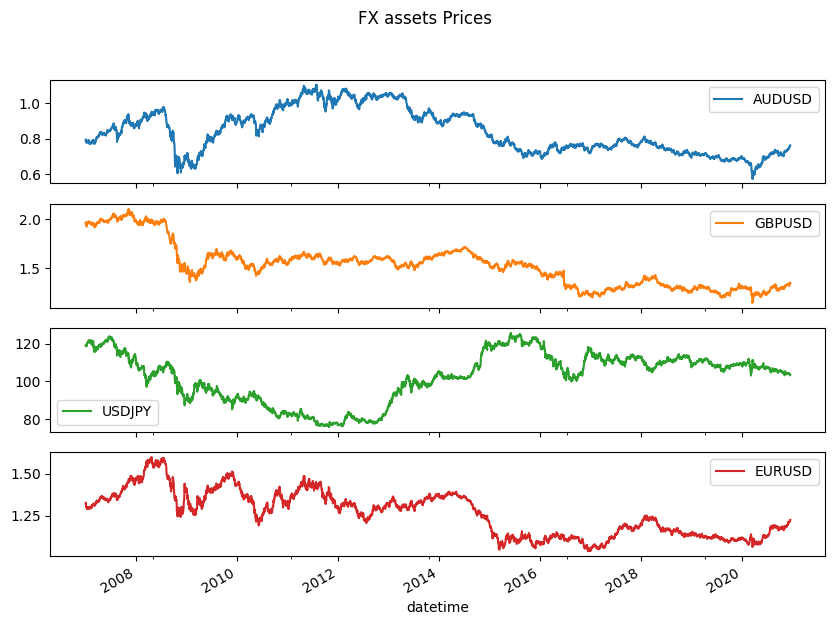

In [6]:
h = {}
# read all data
for i in range(len(paths)):
    h["asset" + str(i)] = read_asset_data(paths[i])
    
# Concat FX prices to one dataframe
prices = pd.concat(h, axis=1)
prices.columns = prices.columns.droplevel()
#prices.fillna(method='pad', axis=0, limit=2,inplace=True)
prices = prices.dropna()
#plot
prices.plot(subplots=True, title='FX assets Prices',figsize=(10, 7))
plt.show()

In [7]:
# asset returns calculation
returns = prices.pct_change().dropna()
# deepar model requires datetime index with constant frequency as input
returns = returns.asfreq(freq='1D', fill_value=0.0)
# we use the last 6 years of the data
returns = returns[returns.index>='2015-01-01']

In [23]:
def combine_into(d: dict, combined: dict) -> None:
    for k, v in d.items():
        if isinstance(v, dict):
            combine_into(v, combined.setdefault(k, {}))
        else:
            combined[k] = v

In [26]:
w = np.ones([4,1]) * 0.25 
var95 = Var.VaRCalculation(time=1, alpha=95, name="Moneda").predict(returns, w)
var99 = Var.VaRCalculation(time=1, alpha=99, name="Moneda").predict(returns, w)

combine_into(var99, var95)
var95



{'Moneda': {'vs_95': -0.004748584144699023,
  'hs_95': -0.004568142114654137,
  'mc_95': -0.004670868501922106,
  'es_95': -0.0059673076918153765,
  'vs_99': -0.006716013175104564,
  'hs_99': -0.008065142121959315,
  'mc_99': -0.006834271797580437,
  'es_99': -0.007706685805217634},
 'Moneda/AUDUSD': {'vs_95': 0.008759197736171993,
  'hs_95': 0.008610881601188234,
  'mc_95': -0.00861034856138651,
  'es_95': -0.011001757842967209,
  'vs_99': 0.012388300513774675,
  'hs_99': 0.01575665783138422,
  'mc_99': -0.01260095636846363,
  'es_99': -0.014210206865361629},
 'Moneda/GBPUSD': {'vs_95': 0.008471061314016258,
  'hs_95': 0.007843235423953527,
  'mc_95': -0.008362026001947536,
  'es_95': -0.010674769161919955,
  'vs_99': 0.01198078367328957,
  'hs_99': 0.013743460093143086,
  'mc_99': -0.01222136157492386,
  'es_99': -0.013777675296731863},
 'Moneda/USDJPY': {'vs_95': 0.007416021036884834,
  'hs_95': 0.006935873144564963,
  'mc_95': -0.007332923540309812,
  'es_95': -0.009357622842024023

In [27]:
import pandas as pd
''' 
mc: Monte Carlo VaR
vc: Variance-covariance VaR
hs: Historical Simulation VaR
es: Expected Shortfall
'''
# Convertir el JSON en un DataFrame
df = pd.DataFrame.from_dict(var95, orient='index')

df

,vs_95,hs_95,mc_95,es_95,vs_99,hs_99,mc_99,es_99
Moneda,-0.004749,-0.004568,-0.004671,-0.005967,-0.006716,-0.008065,-0.006834,-0.007707
Moneda/AUDUSD,0.008759,0.008611,-0.008610,-0.011002,0.012388,0.015757,-0.012601,-0.014210
Moneda/GBPUSD,0.008471,0.007843,-0.008362,-0.010675,0.011981,0.013743,-0.012221,-0.013778
Moneda/USDJPY,0.007416,0.006936,-0.007333,-0.009358,0.010489,0.012416,-0.010712,-0.012074
Moneda/EURUSD,0.007145,0.007045,-0.006994,-0.008945,0.010106,0.011892,-0.010249,-0.011562
